# Loading Data

In [3]:
# https://www.figure-eight.com/data-for-everyone/

In [4]:
# pip install requests
import requests

# url = 'https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Apple-Twitter-Sentiment-DFE.csv'
url = 'https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Airline-Sentiment-2-w-AA.csv'
r = requests.get(url)

In [5]:
from io import StringIO

df = pd.read_csv(StringIO(r.text), sep=",") 

In [6]:
df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'airline_sentiment',
       'airline_sentiment:confidence', 'negativereason',
       'negativereason:confidence', 'airline', 'airline_sentiment_gold',
       'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

In [7]:
df.shape

(14640, 20)

In [8]:
df['airline_sentiment'].value_counts() / df['airline_sentiment'].shape[0]

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

In [9]:
df['negativereason'].value_counts() / df['airline_sentiment'].shape[0]

Customer Service Issue         0.198770
Late Flight                    0.113730
Can't Tell                     0.081284
Cancelled Flight               0.057855
Lost Luggage                   0.049454
Bad Flight                     0.039617
Flight Booking Problems        0.036134
Flight Attendant Complaints    0.032855
longlines                      0.012158
Damaged Luggage                0.005055
Name: negativereason, dtype: float64

In [10]:
pd.options.display.max_colwidth = 120

In [11]:
df[['text', 'airline', 'airline_sentiment:confidence', 'airline_sentiment']].sample(20)

,text,airline,airline_sentiment:confidence,airline_sentiment
7303,@JetBlue im still waiting??? No answer!!,Delta,1.0000,negative
14438,@AmericanAir I will thank you. What do I do if I can't get through and my flight on hold Cancelled Flights?,American,0.7026,neutral
7592,@JetBlue have a cpap machine for sleep apnea. Is this OK to carry on if I also have a small bag for clothes?,Delta,1.0000,neutral
10207,@USAirways My bags were supposed to be delivered to NYC last night (missing since Thurs) but are not here. Can someo...,US Airways,1.0000,negative
7057,@JetBlue also. My party { me and my sister and mom} are on three separate reservations. Will TSA lets us go through ...,Delta,1.0000,neutral
5139,@SouthwestAir Thanks for making good on @PoteetTJ 's Cancelled Flightled flight.,Southwest,0.6680,positive
8371,@JetBlue i am here - what is your resolution?,Delta,0.6201,negative
3973,"@united That made me so mad, but then I called the bag number, and that person was helpful and told me where the bag...",United,0.6301,positive
309,@VirginAmerica is saving my sanity right now: http://t.co/ELtBOLjUl9,Virgin America,0.3750,neutral
2798,@united or frontier ... http://t.co/n8WiNFu6C5,United,1.0000,neutral


In [12]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df)

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train = le.fit_transform(df_train['airline_sentiment'])
y_test = le.transform(df_test['airline_sentiment'])

# y_train = df_train['airline_sentiment']
# y_test = df_test['airline_sentiment']

In [15]:
le.classes_.tolist()

['negative', 'neutral', 'positive']

In [102]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(ngram_range=(1,3), min_df=3, max_df=0.2, strip_accents='ascii')

x_train = vec.fit_transform(df_train['text'])
x_test = vec.transform(df_test['text'])

In [103]:
pd.DataFrame(vec.vocabulary_.items(), columns=['token', 'id']).sort_values('id').set_index('id')

,token
id,
0,00
1,00 pm
2,000
3,000 feet
4,000 miles
...,...
18303,yvr
18304,yvr to
18305,yyz


In [104]:
x_train

<10980x18308 sparse matrix of type '<class 'numpy.int64'>'
	with 254249 stored elements in Compressed Sparse Row format>

In [105]:
x_test

<3660x18308 sparse matrix of type '<class 'numpy.int64'>'
	with 78977 stored elements in Compressed Sparse Row format>

In [106]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(fit_prior=True)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)

,Precision,Recall,F,Support
negative,0.848980,0.902386,0.874869,2305
neutral,0.693023,0.576774,0.629577,775
positive,0.700885,0.682759,0.691703,580


In [107]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

0.7986338797814208

In [108]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(fit_prior=False)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)

,Precision,Recall,F,Support
negative,0.881349,0.873319,0.877315,2305
neutral,0.663475,0.625806,0.644090,775
positive,0.668217,0.743103,0.703673,580


In [109]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

0.8002732240437158

Micro FScore = 0.7852459016393442 @ ngram_range = (1, 1)
Micro FScore = 0.7314207650273225 @ ngram_range = (2, 2)
Micro FScore = 0.6344262295081967 @ ngram_range = (3, 3)
Micro FScore = 0.6418032786885246 @ ngram_range = (4, 4)
Micro FScore = 0.6398907103825137 @ ngram_range = (5, 5)
Micro FScore = 0.6377049180327868 @ ngram_range = (6, 6)
Micro FScore = 0.6360655737704918 @ ngram_range = (7, 7)
Micro FScore = 0.6352459016393442 @ ngram_range = (8, 8)


/Users/tarek/anaconda3/envs/scikitbook/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


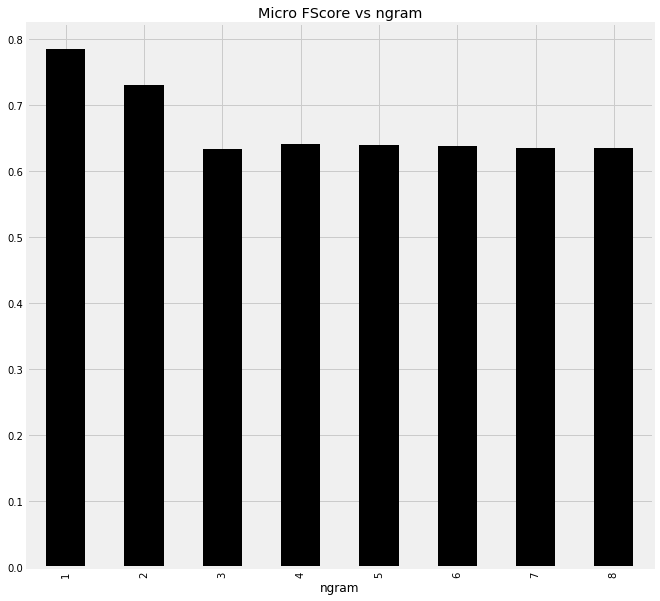

In [130]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

micro_fscores = []

for ngram_range in [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8)]:

    pipeline = make_pipeline(
        CountVectorizer(ngram_range=ngram_range, min_df=3, max_df=0.2, strip_accents='ascii'),
        MultinomialNB(fit_prior=False)
    )

    pipeline.fit(df_train['text'], y_train)
    y_test_pred =  pipeline.predict(df_test['text'])

    p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

    micro_fscore = precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

    print(f'Micro FScore = {micro_fscore} @ ngram_range = {ngram_range}')
    
    micro_fscores.append([ngram_range[-1], micro_fscore])
    
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

pd.DataFrame(
    micro_fscores,
    columns=['ngram', 'Micro FScore']
).set_index('ngram')['Micro FScore'].plot(
    title='Micro FScore vs ngram',
    color='k',
    kind='bar',
    ax=ax,
)

fig.show()

/Users/tarek/anaconda3/envs/scikitbook/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


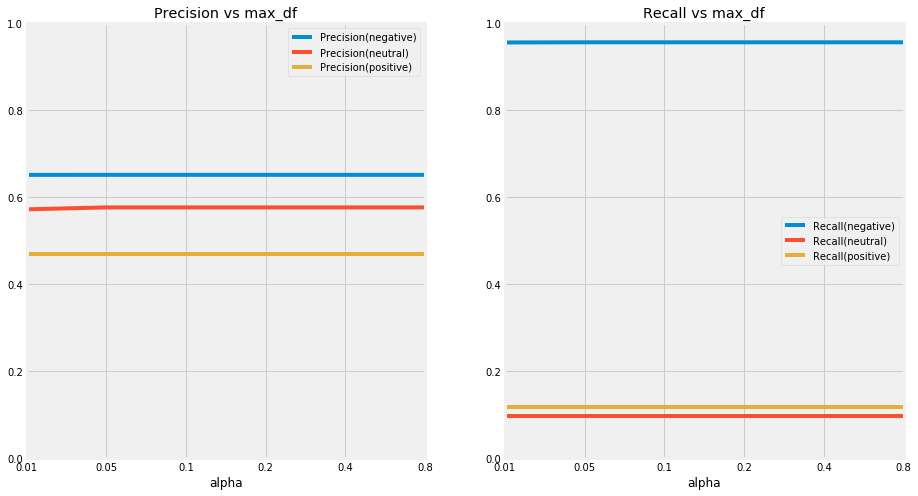

In [163]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

precision_scores = []
recall_scores = []

for max_df in [.01, .05, .1, .2, .4, .8]:

    pipeline = make_pipeline(
        CountVectorizer(ngram_range=(4,4), min_df=3, max_df=max_df, strip_accents='ascii'),
        MultinomialNB(fit_prior=False, alpha=1)
    )

    pipeline.fit(df_train['text'], y_train)
    y_test_pred =  pipeline.predict(df_test['text'])

    p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)
    
    precision_score = [f'{max_df}']
    precision_score.extend(p)
    
    recall_score = [f'{max_df}']
    recall_score.extend(r)
    
    precision_scores.append(precision_score)
    recall_scores.append(recall_score)
    
fig, axs = plt.subplots(1, 2, figsize=(14, 8))

pd.DataFrame(
    precision_scores,
    columns=['alpha', 'Precision(negative)', 'Precision(neutral)', 'Precision(positive)']
).set_index('alpha').plot(
    title='Precision vs max_df',
    # color='k',
    kind='line',
    ylim=(0,1),
    ax=axs[0],
)

pd.DataFrame(
    recall_scores,
    columns=['alpha', 'Recall(negative)', 'Recall(neutral)', 'Recall(positive)']
).set_index('alpha').plot(
    title='Recall vs max_df',
    # color='k',
    kind='line',
    ylim=(0,1),
    ax=axs[1],
)

fig.show()

In [132]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(ngram_range=(1,3), min_df=3, max_df=0.2, binary=True, strip_accents='ascii')

x_train = vec.fit_transform(df_train['text'])
x_test = vec.transform(df_test['text'])

In [330]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB(fit_prior=False)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)

,Precision,Recall,F,Support
negative,0.891244,0.851982,0.871171,2270
neutral,0.611857,0.688917,0.648104,794
positive,0.691275,0.691275,0.691275,596


In [331]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

0.7904371584699453

In [322]:
df_vocab = pd.DataFrame(vec.vocabulary_.items(), columns=['token', 'id']).sort_values('id').set_index('id')

c1, c2, c3 = clf.coef_

df_vocab['negative_coef'] = c1
df_vocab['neutral_coef'] = c2
df_vocab['positive_coef'] = c3

In [323]:
df_vocab.sort_values('negative_coef', ascending=False).head(20)

,token,negative_coef,neutral_coef,positive_coef
id,,,,
9710,my,-1.481894,-1.938568,-2.031432
7784,is,-1.597212,-1.897264,-2.378303
7481,in,-1.764071,-2.000700,-2.075492
10566,of,-1.869056,-2.246535,-2.330675
8034,it,-1.869056,-2.056728,-2.084542
10289,not,-1.994845,-3.070874,-3.452818
18425,your,-2.000178,-2.973019,-2.296386
9245,me,-2.006616,-2.288382,-2.279673
13176,southwestair,-2.030582,-1.525103,-1.430798


In [324]:
df_vocab.sort_values('positive_coef', ascending=False).head(20)

,token,negative_coef,neutral_coef,positive_coef
id,,,,
13892,thanks,-3.385404,-2.973019,-1.360072
13176,southwestair,-2.030582,-1.525103,-1.430798
8239,jetblue,-2.211362,-1.476503,-1.489208
13869,thank,-4.651070,-3.851883,-1.697426
13873,thank you,-4.763187,-3.915062,-1.748070
9710,my,-1.481894,-1.938568,-2.031432
7481,in,-1.764071,-2.000700,-2.075492
8034,it,-1.869056,-2.056728,-2.084542
9245,me,-2.006616,-2.288382,-2.279673


In [325]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)


/Users/tarek/anaconda3/envs/scikitbook/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Precision,Recall,F,Support
negative,0.854202,0.895595,0.874409,2270
neutral,0.645638,0.605793,0.625081,794
positive,0.749533,0.672819,0.709107,596


In [326]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

0.7964480874316942

In [342]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(ngram_range=(1,3), sublinear_tf=True)

x_train = vec.fit_transform(df_train['text'])
x_test = vec.transform(df_test['text'])

In [343]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(fit_prior=False, alpha=0.001)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)

,Precision,Recall,F,Support
negative,0.804869,0.917621,0.857555,2270
neutral,0.648551,0.450882,0.531947,794
positive,0.694231,0.605705,0.646953,596


In [344]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[1]

0.7655737704918033

In [345]:
df_vocab = pd.DataFrame(vec.vocabulary_.items(), columns=['token', 'id']).sort_values('id').set_index('id')

c1, c2, c3 = clf.coef_

df_vocab['negative_coef'] = c1
df_vocab['neutral_coef'] = c2
df_vocab['positive_coef'] = c3

In [346]:
df_vocab.sort_values('negative_coef', ascending=False).head(20)

,token,negative_coef,neutral_coef,positive_coef
id,,,,
191557,to,-5.915192,-5.828423,-6.100844
181012,the,-6.116753,-6.152994,-5.871366
202738,united,-6.232380,-6.088073,-6.012418
68961,flight,-6.257911,-6.453387,-6.662051
18665,and,-6.294188,-6.808669,-6.513998
138807,on,-6.297872,-6.328405,-6.743613
208293,usairways,-6.299983,-6.626311,-6.446595
226678,you,-6.341896,-6.138289,-5.509187
74982,for,-6.352966,-6.487227,-6.033189


In [348]:
# pip install spacy
# python -m spacy download en_core_web_lg

In [1]:
%autoreload

reload(spacy)

UsageError: Line magic function `%autoreload` not found.


In [2]:
import spacy

nlp = spacy.load('en_core_web_md')

In [33]:
from tqdm import tqdm
tqdm.pandas()

In [91]:
import spacy

class WordEmbeddingVectorizer:
    
    def __init__(self, language_model='en_core_web_md'):
        self.nlp = spacy.load(language_model)
    
    def fit(self):
        pass
    
    def transform(self, x, y=None):
        return pd.Series(x).progress_apply(
            lambda doc: self.nlp(doc).vector.tolist()
        ).values.tolist()
    
    def fit_transform(self, x, y=None):
        return self.transform(x)
    

vec = WordEmbeddingVectorizer()
x_train_w2v = vec.transform(df_train['text'])
x_test_w2v = vec.transform(df_test['text'])

100%|██████████| 3660/3660 [00:50<00:00, 73.01it/s] 


In [92]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

scaler = StandardScaler()
# clf = SGDClassifier(loss='log', max_iter=10000, class_weight='balanced')
clf = LogisticRegression(max_iter=10000, class_weight=None)

x_train_scaled = scaler.fit_transform(x_train_w2v)
x_test_scaled = scaler.transform(x_test_w2v)

clf.fit(x_train_scaled, y_train)
y_test_pred = clf.predict(x_test_scaled)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)


,Precision,Recall,F,Support
negative,0.846433,0.911063,0.877560,2305
neutral,0.653614,0.560000,0.603197,775
positive,0.724272,0.643103,0.681279,580


In [93]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[1]

0.7942622950819672

In [94]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3, metric='cosine')

clf.fit(x_train_w2v, y_train)
y_test_pred = clf.predict(x_test_w2v)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)


,Precision,Recall,F,Support
negative,0.744674,0.940130,0.831064,2305
neutral,0.671779,0.282581,0.397820,775
positive,0.667453,0.487931,0.563745,580


In [95]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[1]

0.7292349726775956

In [97]:
# ELMo and BERT can generate different word embeddings for a word that captures the context of a word - 
# that is its position in a sentence.
# https://www.quora.com/What-are-the-main-differences-between-the-word-embeddings-of-ELMo-BERT-Word2vec-and-GloVe